In [1]:
import os
import sys
# you probably don't need this, but I had trouble importing packages because I used a virtual env
sys.path.append(os.path.join(os.getcwd(), 'venv\Lib\site-packages'))

from dotenv import load_dotenv
from knowledge.elastic_client import ElasticConfig
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
class GraphComposer:
    def __init__(self, graph_dict, linking_instructions):
        self.graph_dict = graph_dict
        self.linking_instructions = linking_instructions
        self.composed_graph = nx.Graph()

    def compose_graphs(self):
        for linking_instruction in self.linking_instructions:
            self._link_graphs(linking_instruction)

    def _link_graphs(self, linking_instruction):
        target = linking_instruction['target']
        source = linking_instruction['source']
        link = linking_instruction['link']
        target_graph = self.graph_dict[target]
        source_graph = self.graph_dict[source]
        
        for source_node in source_graph.nodes(data=True):
            target_node = next(filter(lambda x: x if link(source_node[1], x[1]) else None, target_graph.nodes(data=True)), None)
            if target_node:
                new_source = source + ":" + source_node[0]
                new_target = target + ":" + target_node[0]
                self.composed_graph.add_node(new_source, **source_node[1])
                self.composed_graph.add_node(new_target, **target_node[1])
                
                self.composed_graph.add_edge(new_source, new_target)
                

    def get_composed_graph(self):
        return self.composed_graph

In [3]:
current_env = 'remote' if os.path.exists('.env') else 'local'

if current_env == 'local':
    dotenv_path = '.env.local'
else:
    dotenv_path = '.env'

load_dotenv(dotenv_path)

esc = ElasticConfig(
    https=current_env != 'local',
    username=os.getenv('ELASTIC_USERNAME'),
    password=os.getenv('ELASTIC_PASSWORD'),
    url=os.getenv('ELASTIC_URL'),
    port=os.getenv('ELASTIC_PORT'))

In [30]:
def map_by_key(d, key):
    by_name = {}
    for item in d:
        by_name[item[key]] = item
    return by_name

esb = esc.get_elastic_client("blocks")
esi = esc.get_elastic_client("items")
esf = esc.get_elastic_client("foods")
ese = esc.get_elastic_client("entities")
esel = esc.get_elastic_client("entityloot")
ess = esc.get_elastic_client("smelting")

blocks = map_by_key(esb.get_all(), 'name')
items = map_by_key(esi.get_all(), 'name')
foods = map_by_key(esf.get_all(), 'name')
entities = map_by_key(ese.get_all(), 'name')
entity_loot = map_by_key(esel.get_all(), 'id')

In [37]:
block_graph = nx.DiGraph()
item_graph = nx.DiGraph()
food_graph = nx.DiGraph()
entity_graph = nx.DiGraph()
entity_loot_graph = nx.DiGraph()

for b in blocks.values():
    block_graph.add_node(b['name'], props=b)

for i in items.values():
    item_graph.add_node(i['name'], props=i)
    
for f in foods.values():
    food_graph.add_node(f['name'], props=f)
    
for e in entities.values():
    entity_graph.add_node(e['name'], props=e)

for el in entity_loot.values():
    entity_loot_graph.add_node(el['id'], props=el)

In [42]:
linkings = [
    {
        'source': 'blocks',
        'target': 'items',
        'link': lambda b, i: i['props']['name'] in [x['name'] for x in b['props']['drops']]
    },
    {
        'source': 'blocks',
        'target': 'items',
        'link': lambda b, i: i['props']['name'] in [x['name'] for x in b['props']['requires']]
    },
    {
        'source': 'items',
        'target': 'foods',
        'link': lambda s, t: s['props']['name'] == t['props']['name'],
    },
    {
        'source': 'entities',
        'target': 'entity_loot',
        'link': lambda e, l: e['props']['name'] == l['props']['entity']
    },
    {
        'source': 'entity_loot',
        'target': 'items',
        'link': lambda el, i: i['props']['name'] in [x['item'] for x in el['props']['drops']]
    }
]

graphs = {
    'blocks': block_graph, 
    'items': item_graph, 
    'foods': food_graph,
    'entities': entity_graph,
    'entity_loot': entity_loot_graph
}

composer = GraphComposer(graphs, linkings)
composer.compose_graphs()

composed_graph = composer.get_composed_graph()

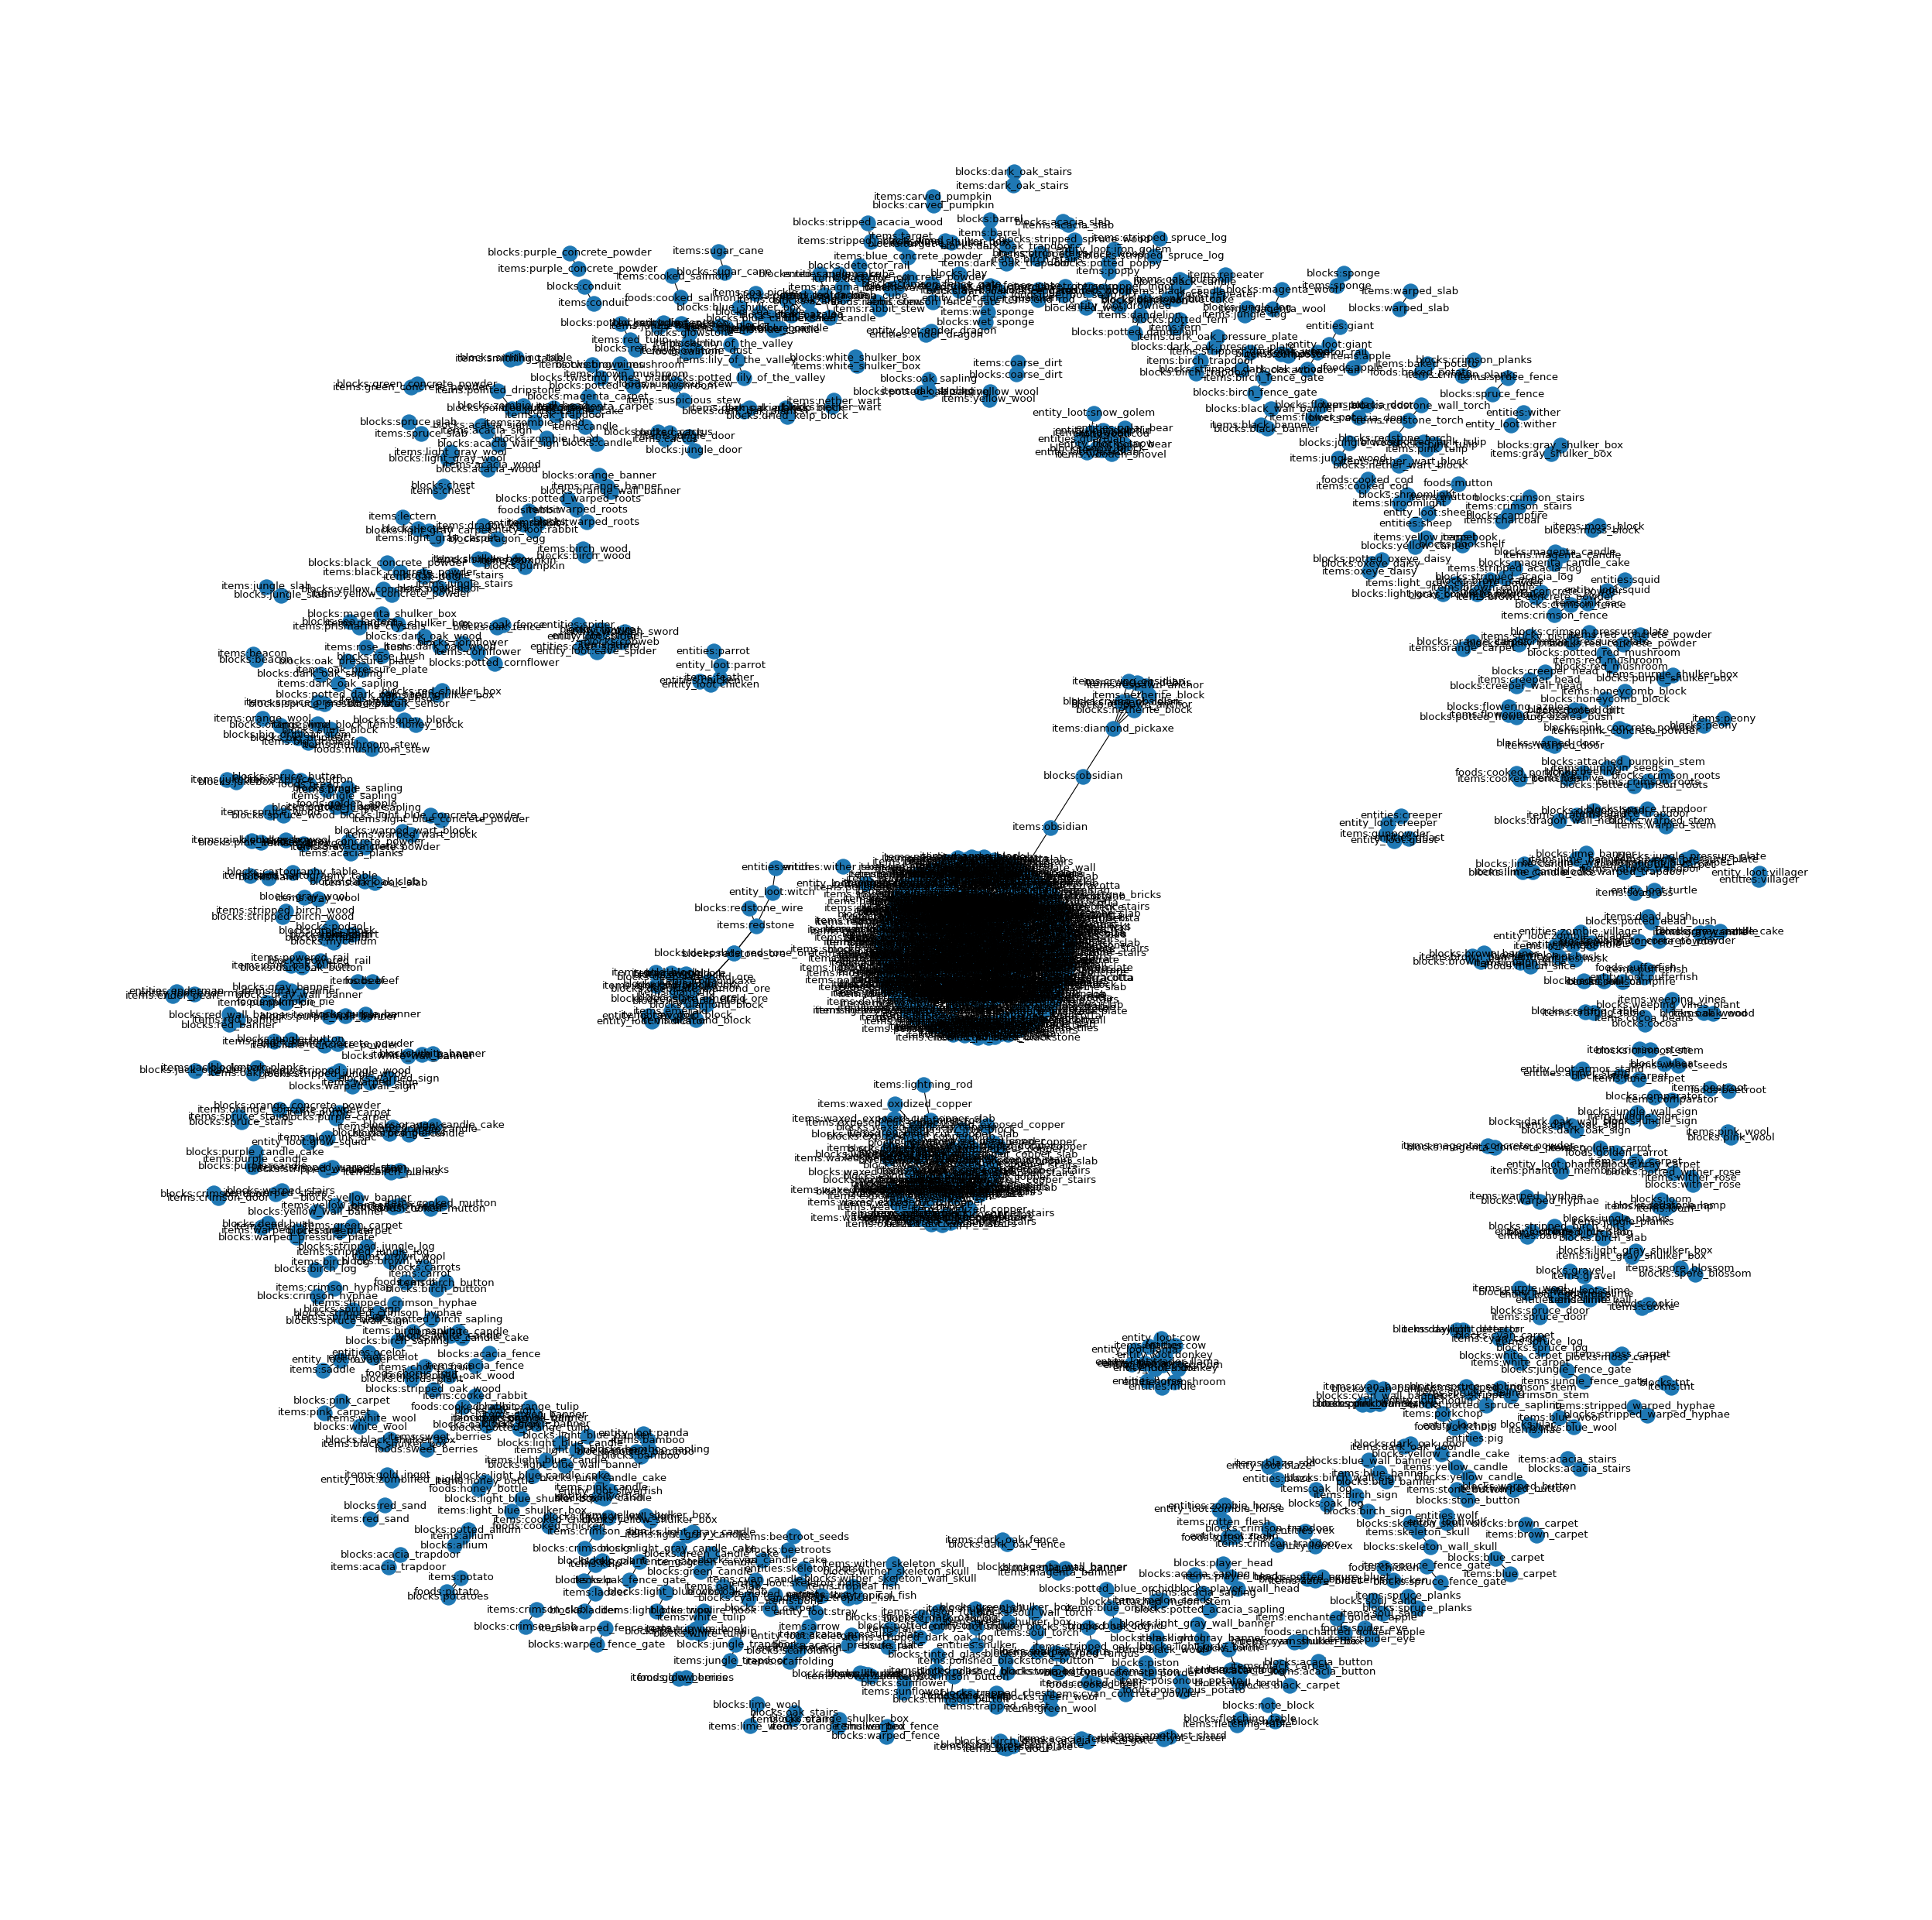

In [43]:
def visualize_graph(graph):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, with_labels=True)

visualize_graph(composed_graph)

In [41]:
nx.shortest_path(composed_graph, "blocks:redstone_wire", "items:emerald_block")

['blocks:redstone_wire',
 'items:redstone',
 'blocks:redstone_ore',
 'items:iron_pickaxe',
 'blocks:emerald_block',
 'items:emerald_block']